## Pulsar Candidate Selection

> - Zhen Zhao
> - zzhao377@gatech.edu

In [1]:
my_random_seed = 903
my_multiple_jobs = 8

In [2]:
learners_name = []    # collect learner names
learners_metric = []  # collect [accuracy, auc, f1-score]
learners_best = []    # collect best_learners

### Packages

In [3]:
%config ZMQInteractiveShell.ast_node_interactivity='all'
%matplotlib inline

In [4]:
import os, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import *
import itertools
import warnings
warnings.filterwarnings("ignore")

### Import data

In [5]:
raw_data = pd.read_csv('HTRU2.csv', header=None)
raw_data.head()

0          1         2         3         4          5          6  \
0  140.562500  55.683782 -0.234571 -0.699648  3.199833  19.110426   7.975532   
1  102.507812  58.882430  0.465318 -0.515088  1.677258  14.860146  10.576487   
2  103.015625  39.341649  0.323328  1.051164  3.121237  21.744669   7.735822   
3  136.750000  57.178449 -0.068415 -0.636238  3.642977  20.959280   6.896499   
4   88.726562  40.672225  0.600866  1.123492  1.178930  11.468720  14.269573   

            7  8  
0   74.242225  0  
1  127.393580  0  
2   63.171909  0  
3   53.593661  0  
4  252.567306  0

In [6]:
raw_data.columns = ["feature1", "feature2", "feature3","feature4",
                    "feature5","feature6","feature7","feature8", "target"]
raw_data.head()

feature1   feature2  feature3  feature4  feature5   feature6   feature7  \
0  140.562500  55.683782 -0.234571 -0.699648  3.199833  19.110426   7.975532   
1  102.507812  58.882430  0.465318 -0.515088  1.677258  14.860146  10.576487   
2  103.015625  39.341649  0.323328  1.051164  3.121237  21.744669   7.735822   
3  136.750000  57.178449 -0.068415 -0.636238  3.642977  20.959280   6.896499   
4   88.726562  40.672225  0.600866  1.123492  1.178930  11.468720  14.269573   

     feature8  target  
0   74.242225       0  
1  127.393580       0  
2   63.171909       0  
3   53.593661       0  
4  252.567306       0

In [7]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
feature1    17898 non-null float64
feature2    17898 non-null float64
feature3    17898 non-null float64
feature4    17898 non-null float64
feature5    17898 non-null float64
feature6    17898 non-null float64
feature7    17898 non-null float64
feature8    17898 non-null float64
target      17898 non-null int64
dtypes: float64(8), int64(1)
memory usage: 1.2 MB


In [8]:
raw_data.describe()

feature1      feature2      feature3      feature4      feature5  \
count  17898.000000  17898.000000  17898.000000  17898.000000  17898.000000   
mean     111.079968     46.549532      0.477857      1.770279     12.614400   
std       25.652935      6.843189      1.064040      6.167913     29.472897   
min        5.812500     24.772042     -1.876011     -1.791886      0.213211   
25%      100.929688     42.376018      0.027098     -0.188572      1.923077   
50%      115.078125     46.947479      0.223240      0.198710      2.801839   
75%      127.085938     51.023202      0.473325      0.927783      5.464256   
max      192.617188     98.778911      8.069522     68.101622    223.392140   

           feature6      feature7      feature8        target  
count  17898.000000  17898.000000  17898.000000  17898.000000  
mean      26.326515      8.303556    104.857709      0.091574  
std       19.470572      4.506092    106.514540      0.288432  
min        7.370432     -3.139270     -1.976976      0.000000  
25%       14.437332      5.781506     34.960504      0.000000  
50%       18.461316      8.433515     83.064556      0.000000  
75%       28.428104     10.702959    139.309331      0.000000  
max      110.642211     34.539844   1191.000837      1.000000

### data visualization

**1) Data Overview**

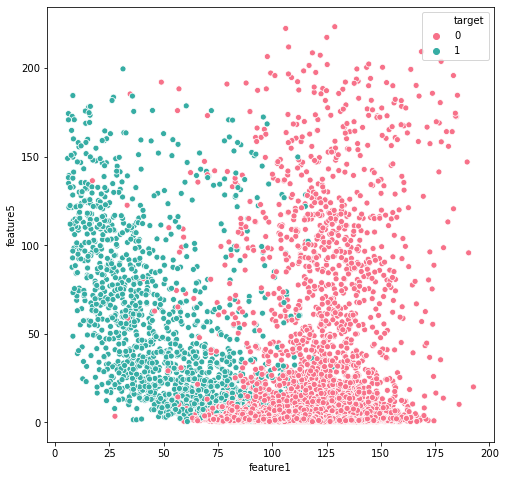

In [9]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=raw_data, x='feature1', y='feature5', hue='target', palette="husl");

**2) Features Pairplots**

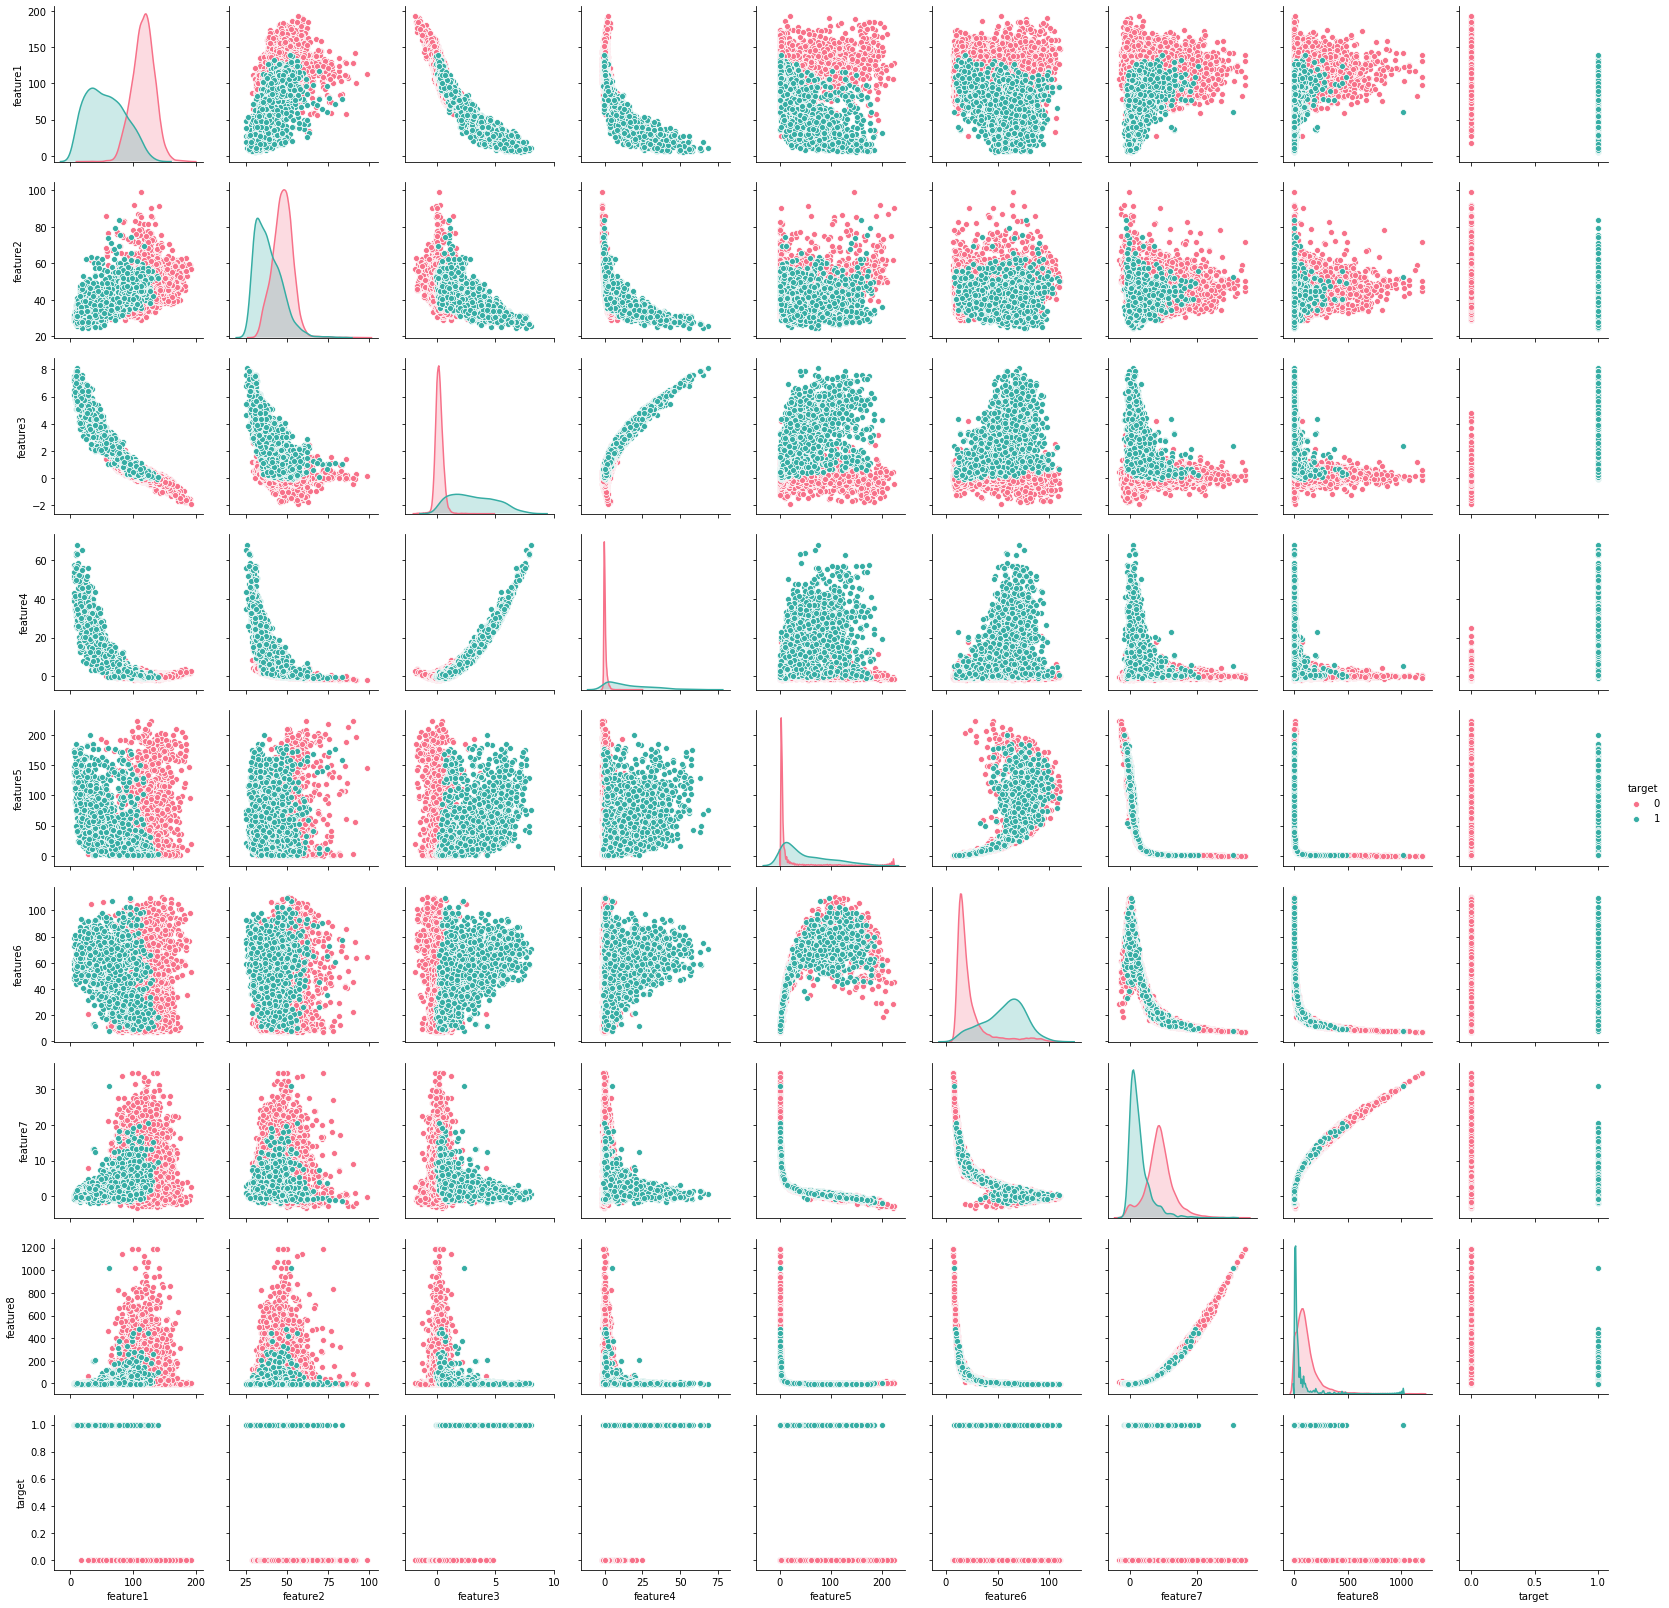

In [10]:
g = sns.pairplot(raw_data, hue="target",palette="husl",diag_kind="kde",kind="scatter")

**3) Feature Correlations**

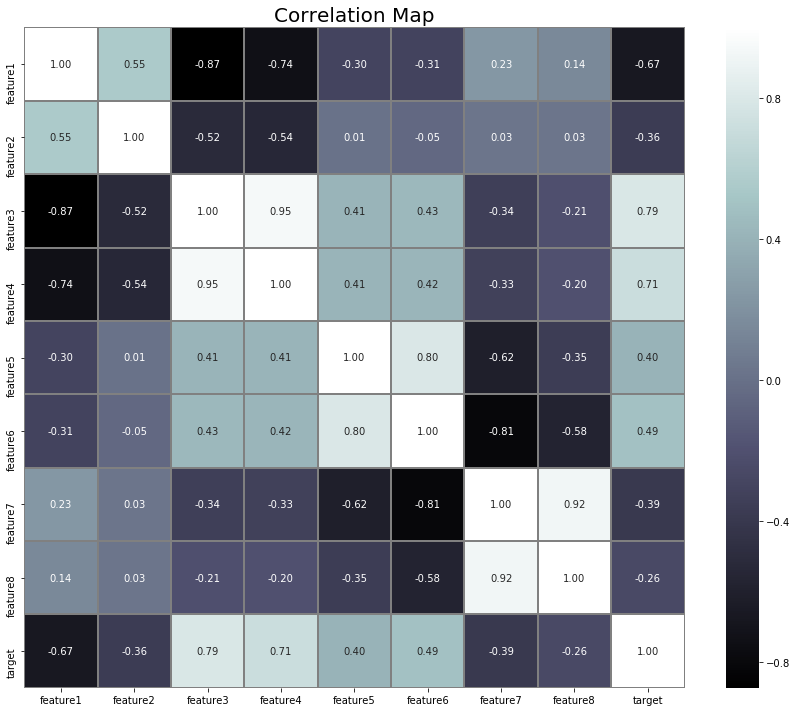

In [11]:
plt.figure(figsize=(12,10))
sns.heatmap(data=raw_data.corr(),annot=True,cmap="bone",linewidths=1,fmt=".2f",linecolor="gray")
plt.title("Correlation Map",fontsize=20)
plt.tight_layout();  
# lightest and darkest cells are most correlated ones

**4) Focus on Two feature**

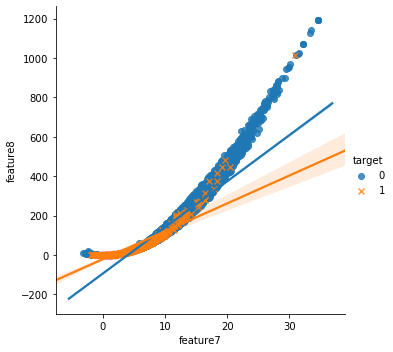

In [12]:
sns.lmplot(x="feature7", y="feature8", hue="target", data=raw_data, markers=["o", "x"]);

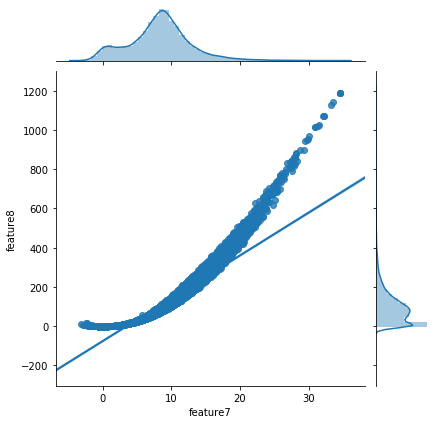

In [13]:
sns.jointplot(x="feature7", y="feature8", data=raw_data, kind='reg');

**5)boxplot for single figure** --> outliers

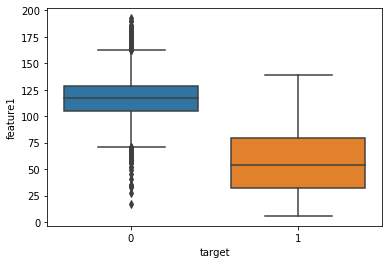

In [14]:
sns.boxplot(y="feature1", x="target", data=raw_data);

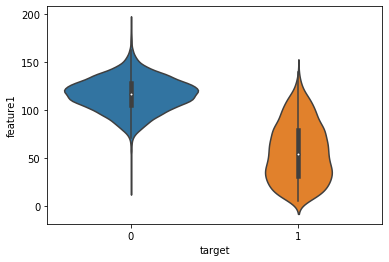

In [15]:
sns.violinplot(y="feature1", x="target", data=raw_data);

### preprocessing

In [16]:
data_X_raw = raw_data.iloc[:, :-1]
data_y = raw_data.iloc[:, -1]
data_X_raw.shape, data_y.shape
# data_X_raw.head()
# data_y.head()

((17898, 8), (17898,))

**normalization**

In [17]:
scaler = MinMaxScaler()
data_X = scaler.fit_transform(data_X_raw.values)
data_X[:3,:]

array([[0.72134164, 0.41768745, 0.16504291, 0.01562717, 0.01338219,
        0.11368057, 0.29498574, 0.06388987],
       [0.51762787, 0.46090841, 0.23541516, 0.01826776, 0.00655997,
        0.0725243 , 0.36401483, 0.10844339],
       [0.52034628, 0.19686832, 0.22113842, 0.04067689, 0.01303002,
        0.13918843, 0.28862387, 0.05461031]])

### train-test split

**train, test split**

In [18]:
# kf = StratifiedKFold(n_splits=2, random_state=my_random_seed)
# for train_index, test_index in kf.split(data_X,data_y):
#     X_train, X_test = data_X[train_index], data_X[test_index]
#     y_train, y_test = data_y[train_index], data_y[test_index] 

In [19]:
# sss = StratifiedShuffleSplit(labels.values,test_size=0.2, random_state=my_random_seed,n_iter=1)

# for train_index, test_index in sss:
#     X_train, X_test = features.values[train_index], features.values[test_index]
#     y_train, y_test = labels.values[train_index], labels.values[test_index]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, 
                                                    test_size=0.2, 
                                                    random_state=my_random_seed)

In [21]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14318, 8), (3580, 8), (14318,), (3580,))

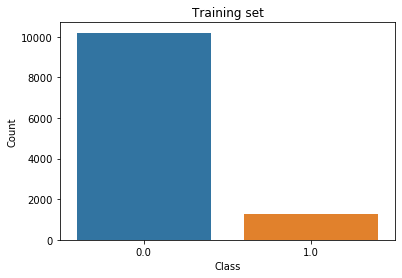

In [22]:
train_data = pd.DataFrame(X_train)
# train_data = X_train.copy()
train_data["target"] = y_train
sns.countplot(x='target', data=train_data)
plt.title('Training set')
plt.xlabel('Class')
plt.ylabel('Count');

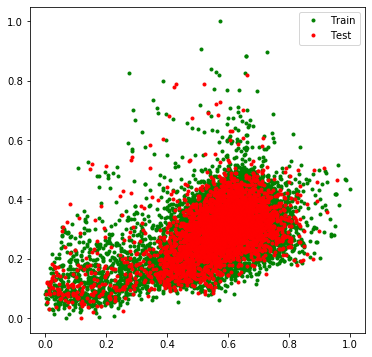

In [23]:
plt.figure(figsize=(6,6))
plt.plot(X_train[:, 0], X_train[:, 1], 'g.', label="Train")
plt.plot(X_test[:, 0], X_test[:, 1], 'r.', label="Test")
plt.legend();

### functions

In [24]:
def plot_cm(cm, classes,
            normalize=False,
            title='Confusion matrix',
            cmap=plt.cm.winter,
            colmap=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    if colmap:
        plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#     plt.grid(None)

In [25]:
def get_learn_curve_data(model, X_in=data_X, y_in=data_y, num_cv=10, num_jobs=my_multiple_jobs):
    train_sizes, train_scores, test_scores = learning_curve(estimator=model, 
                                                            X=X_in, y=y_in, 
                                                            train_sizes=np.linspace(0.1, 1.0, 10), 
                                                            cv=num_cv, 
                                                            n_jobs=num_jobs)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    return [train_sizes, train_mean, train_std, test_mean, test_std]

def draw_learn_curve(res1, y_limit):
    plt.figure(figsize=(10,5))
    plt.plot(res1[0], res1[1], color='blue', marker='o', markersize=5, label='Training')
    plt.fill_between(res1[0], res1[1] + res1[2], res1[1] - res1[2], alpha=0.15, color='blue')
    plt.plot(res1[0], res1[3], color='green', linestyle='--', marker='s', markersize=5, label='Testing')
    plt.fill_between(res1[0], res1[3] + res1[4], res1[3] - res1[4], alpha=0.15, color='green')
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.ylim(y_limit)
    plt.grid()

In [26]:
def get_validation_curve_data(model, p_name, p_range, X_in=X_train, y_in=y_train,  
                         num_cv=10, num_jobs=my_multiple_jobs):
    train_scores, test_scores = validation_curve(estimator=model, X=X_in, y=y_in, 
                                             param_name=p_name, param_range=p_range, 
                                             cv=num_cv, n_jobs=num_jobs)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    return [param_range, train_mean, train_std, test_mean, test_std]
    
def draw_validation_curve(res, y_limit):
    plt.figure(figsize=(10,5))
    plt.plot(res[0], res[1], color='blue', marker='o', markersize=5, label='training accuracy')
    plt.fill_between(res[0], res[1] + res[2], res[1] - res[2], alpha=0.15, color='blue')
    plt.plot(res[0], res[3], color='green', linestyle='--', marker='s', markersize=5, label='test accuracy')
    plt.fill_between(res[0], res[3] + res[4], res[3] - res[4], alpha=0.15, color='green')
    plt.xscale('log')
    plt.xlabel(para_name)
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.ylim(y_limit)
    plt.grid()

## Learning Algorithms

### KNN

In [27]:
learners_name.append("KNN")

#### Initilization

In [28]:
model = KNeighborsClassifier()
tuned_parameters = {'n_neighbors': [2, 4, 6, 10, 15]}

#### Training and optimizations

In [29]:
clf = GridSearchCV(estimator=model,
                   param_grid=tuned_parameters,
                   cv=5,
                   scoring='accuracy',
                   refit=True, 
                   n_jobs=my_multiple_jobs);
start = time.time()
clf.fit(X_train, y_train)
print(clf.best_estimator_)

# timing
end = time.time()
duration = end - start

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=8,
             param_grid={'n_neighbors': [2, 4, 6, 10, 15]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='uniform')


In [30]:
learners_best.append(clf.best_estimator_)

#### Performance analysis

In [31]:
print("Validating V.S. Testing:")
# verification
train_score = clf.score(X_train, y_train)
print('\tValidation Accuracy：{:.3f}%'.format(train_score * 100))

# test
test_score = clf.score(X_test, y_test)
print('\tTesting Accuracy：{:.3f}%'.format(test_score * 100))

print("More classification metrics:")
y_pred = clf.predict(X_test)
y_test_cmp = np.array(y_test)

metrc = recall_score(y_test_cmp,y_pred)
metpr = precision_score(y_test_cmp,y_pred)
metauc = roc_auc_score(y_test_cmp,y_pred)
metac = accuracy_score(y_test_cmp,y_pred)
metf1 = f1_score(y_test_cmp,y_pred)
cm = confusion_matrix(y_test_cmp,y_pred)
metfp = 1.*cm[0,1]/(cm[0,0]+cm[0,1])

print("\tThe Running Time is     {:.4f}s".format(duration))
print("\tThe accuracy is         {0:0.4f}".format(np.mean(metac)))
print("\tThe recall score is     {0:0.4f}".format(np.mean(metrc)))
print("\tThe precision score is  {0:0.4f}".format(np.mean(metpr)))
print("\tThe AUC score is        {0:0.4f}".format(np.mean(metauc)))
print("\tThe f1 score is         {0:0.4f}".format(np.mean(metf1)))
print("\tThe FPR is              {0:0.4e}".format(np.mean(metfp)))

Validating V.S. Testing:
	Validation Accuracy：97.884%
	Testing Accuracy：97.849%
More classification metrics:
	The Running Time is     1.5799s
	The accuracy is         0.9785
	The recall score is     0.8198
	The precision score is  0.9414
	The AUC score is        0.9073
	The f1 score is         0.8764
	The FPR is              5.2356e-03


In [32]:
learners_metric.append([train_score, test_score, duration, np.mean(metf1), np.mean(metpr), np.mean(metrc)])

In [33]:
learners_metric

[[0.9788378265120827,
  0.9784916201117319,
  1.579892873764038,
  0.8764044943820224,
  0.9413793103448276,
  0.8198198198198198]]

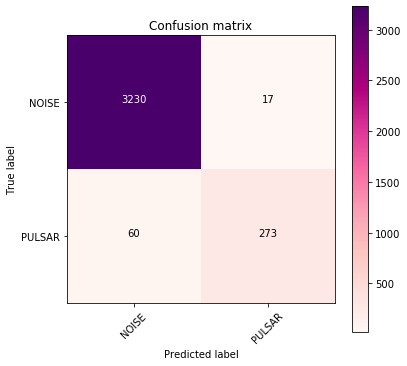

In [34]:
plot_cm(cm,['NOISE','PULSAR'], cmap=plt.cm.RdPu, colmap=True)

#### Learning and Validating curve

In [35]:
# learning curve
lc_res = get_learn_curve_data(model)

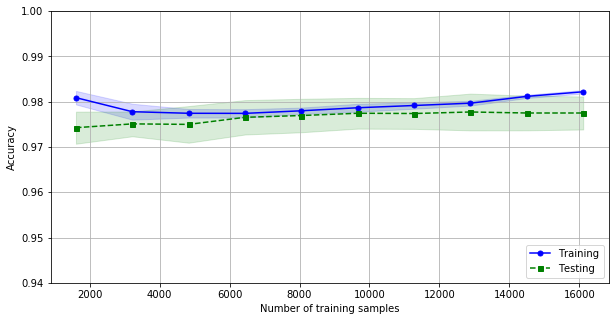

In [36]:
draw_learn_curve(lc_res, [0.94, 1.0])

In [37]:
# validation curve
para_name = list(tuned_parameters.keys())[0]
param_range = list(tuned_parameters.values())[0]
vc_res = get_validation_curve_data(model, para_name, param_range)

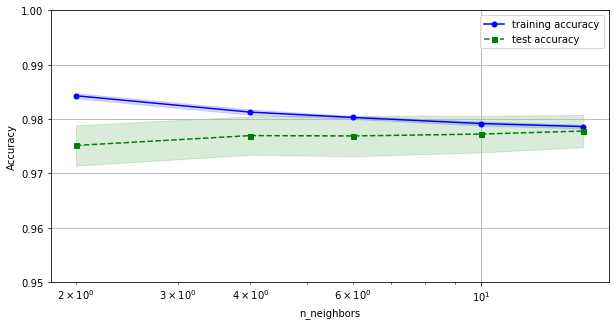

In [38]:
draw_validation_curve(vc_res, [0.95, 1.0]);

### SVM

In [39]:
learners_name.append("SVM")

#### initilization

In [40]:
model = SVC(probability=True, random_state=my_random_seed)
tuned_parameters = {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['linear', 'rbf']}

#### training and optimizations

In [41]:
clf = GridSearchCV(estimator=model,
                   param_grid=tuned_parameters,
                   cv=5,
                   scoring='accuracy',
                   refit=True, n_jobs=my_multiple_jobs);
start = time.time()
clf.fit(X_train, y_train)
print(clf.best_estimator_)

# timing
end = time.time()
duration = end - start

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=True, random_state=903, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=8,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'kernel': ['linear', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=903, shrinking=True, tol=0.001,
    verbose=False)


In [42]:
learners_best.append(clf.best_estimator_)

#### Performance analysis

In [43]:
print("Validating V.S. Testing:")
# verification
train_score = clf.score(X_train, y_train)
print('\tValidation Accuracy：{:.3f}%'.format(train_score * 100))

# test
test_score = clf.score(X_test, y_test)
print('\tTesting Accuracy：{:.3f}%'.format(test_score * 100))

print("More classification metrics:")
y_pred = clf.predict(X_test)
y_test_cmp = np.array(y_test)

metrc = recall_score(y_test_cmp,y_pred)
metpr = precision_score(y_test_cmp,y_pred)
metauc = roc_auc_score(y_test_cmp,y_pred)
metac = accuracy_score(y_test_cmp,y_pred)
metf1 = f1_score(y_test_cmp,y_pred)
cm = confusion_matrix(y_test_cmp,y_pred)
metfp = 1.*cm[0,1]/(cm[0,0]+cm[0,1])

print("\tThe Running Time is     {:.4f}s".format(duration))
print("\tThe accuracy is         {0:0.4f}".format(np.mean(metac)))
print("\tThe recall score is     {0:0.4f}".format(np.mean(metrc)))
print("\tThe precision score is  {0:0.4f}".format(np.mean(metpr)))
print("\tThe AUC score is        {0:0.4f}".format(np.mean(metauc)))
print("\tThe f1 score is         {0:0.4f}".format(np.mean(metf1)))
print("\tThe FPR is              {0:0.4e}".format(np.mean(metfp)))

Validating V.S. Testing:
	Validation Accuracy：98.142%
	Testing Accuracy：97.821%
More classification metrics:
	The Running Time is     18.2207s
	The accuracy is         0.9782
	The recall score is     0.8168
	The precision score is  0.9412
	The AUC score is        0.9058
	The f1 score is         0.8746
	The FPR is              5.2356e-03


In [44]:
learners_metric.append([train_score, test_score, duration, np.mean(metf1), np.mean(metpr), np.mean(metrc)])

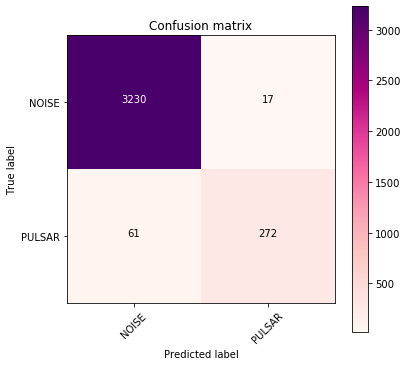

In [45]:
plot_cm(cm,['NOISE','PULSAR'], cmap=plt.cm.RdPu, colmap=True)

#### Learning and Validating curve

In [46]:
model1 = SVC(probability=True, random_state=my_random_seed, kernel='linear')
model2 = SVC(probability=True, random_state=my_random_seed, kernel='rbf')

In [47]:
res1 = get_learn_curve_data(model1)
res2 = get_learn_curve_data(model2)

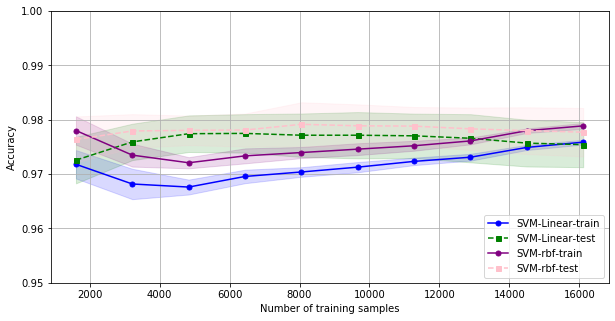

In [48]:
plt.figure(figsize=(10,5))

# model 1
plt.plot(res1[0], res1[1], color='blue', marker='o', markersize=5, label='SVM-Linear-train')
plt.fill_between(res1[0], res1[1] + res1[2], res1[1] - res1[2], alpha=0.15, color='blue')
plt.plot(res1[0], res1[3], color='green', linestyle='--', marker='s', markersize=5, label='SVM-Linear-test')
plt.fill_between(res1[0], res1[3] + res1[4], res1[3] - res1[4], alpha=0.15, color='green')

# model2
plt.plot(res2[0], res2[1], color='purple', marker='o', markersize=5, label='SVM-rbf-train')
plt.fill_between(res2[0], res2[1] + res2[2], res2[1] - res2[2], alpha=0.15, color='purple')
plt.plot(res2[0], res2[3], color='pink', linestyle='--', marker='s', markersize=5, label='SVM-rbf-test')
plt.fill_between(res2[0], res2[3] + res2[4], res2[3] - res2[4], alpha=0.15, color='pink')

plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.95, 1.0])
plt.grid();

In [49]:
# validation curve
para_name = list(tuned_parameters.keys())[0]
param_range = list(tuned_parameters.values())[0]
vc_res = get_validation_curve_data(model2, para_name, param_range)

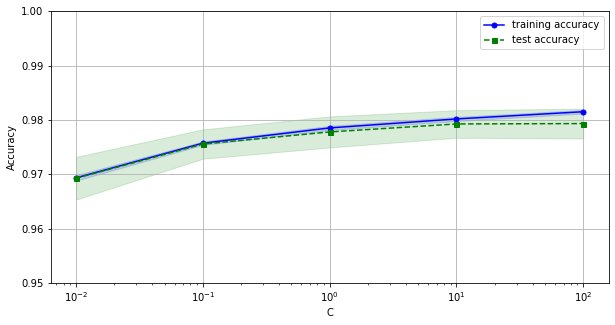

In [50]:
draw_validation_curve(vc_res,[0.95, 1.0])

### Decision Tree

In [51]:
learners_name.append("DTree")

#### initilization

In [52]:
model = DecisionTreeClassifier(criterion='gini', 
                               min_samples_leaf =10, 
                               min_samples_split=10, 
                               random_state=my_random_seed)
tuned_parameters = {'max_depth': [10, 15, 20, 25, 30]}

#### Training and optimizations

In [53]:
clf = GridSearchCV(estimator=model,
                   param_grid=tuned_parameters,
                   cv=5,
                   scoring='accuracy',
                   refit=True, 
                   n_jobs=my_multiple_jobs);
start = time.time()
clf.fit(X_train, y_train)
print(clf.best_estimator_)

# timing
end = time.time()
duration = end - start

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=10,
                                              min_samples_split=10,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=903,
                                              splitter='best'),
             iid='deprecated', n_jobs=8,
             param_grid={'max_depth': [10, 15, 20, 25, 30]},
             pre_di

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=15, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=903, splitter='best')


In [54]:
learners_best.append(clf.best_estimator_)

#### Performance analysis

In [55]:
all(clf.predict(X_test) == clf.best_estimator_.predict(X_test))

True

In [56]:
print("Validating V.S. Testing:")
# verification
train_score = clf.score(X_train, y_train)
print('\tValidation Accuracy：{:.3f}%'.format(train_score * 100))

# test
test_score = clf.score(X_test, y_test)
print('\tTesting Accuracy：{:.3f}%'.format(test_score * 100))

print("More classification metrics:")
y_pred = clf.predict(X_test)
y_test_cmp = np.array(y_test)

metrc = recall_score(y_test_cmp,y_pred)
metpr = precision_score(y_test_cmp,y_pred)
metauc = roc_auc_score(y_test_cmp,y_pred)
metac = accuracy_score(y_test_cmp,y_pred)
metf1 = f1_score(y_test_cmp,y_pred)
cm = confusion_matrix(y_test_cmp,y_pred)
metfp = 1.*cm[0,1]/(cm[0,0]+cm[0,1])

print("\tThe Running Time is     {:.4f}s".format(duration))
print("\tThe accuracy is         {0:0.4f}".format(np.mean(metac)))
print("\tThe recall score is     {0:0.4f}".format(np.mean(metrc)))
print("\tThe precision score is  {0:0.4f}".format(np.mean(metpr)))
print("\tThe AUC score is        {0:0.4f}".format(np.mean(metauc)))
print("\tThe f1 score is         {0:0.4f}".format(np.mean(metf1)))
print("\tThe FPR is              {0:0.4e}".format(np.mean(metfp)))

Validating V.S. Testing:
	Validation Accuracy：98.352%
	Testing Accuracy：97.821%
More classification metrics:
	The Running Time is     0.4332s
	The accuracy is         0.9782
	The recall score is     0.8318
	The precision score is  0.9264
	The AUC score is        0.9125
	The f1 score is         0.8766
	The FPR is              6.7755e-03


In [57]:
learners_metric.append([train_score, test_score, duration, np.mean(metf1), np.mean(metpr), np.mean(metrc)])

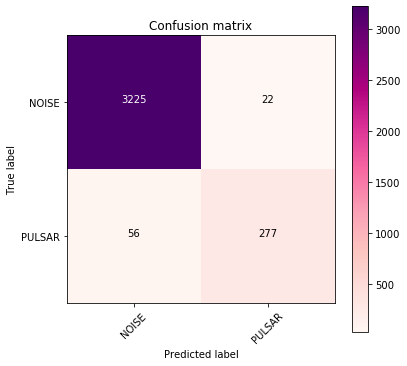

In [58]:
plot_cm(cm,['NOISE','PULSAR'], cmap=plt.cm.RdPu, colmap=True)

#### Learning and Validating curve

In [59]:
# learning curve
lc_res = get_learn_curve_data(model)

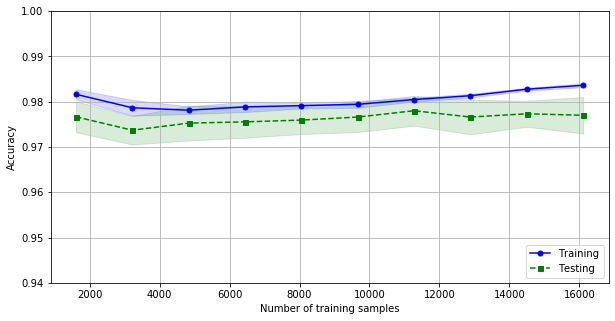

In [60]:
draw_learn_curve(lc_res, [0.94, 1.0])

In [61]:
# validation curve
para_name = list(tuned_parameters.keys())[0]
param_range = list(tuned_parameters.values())[0]
vc_res = get_validation_curve_data(model, para_name, param_range)

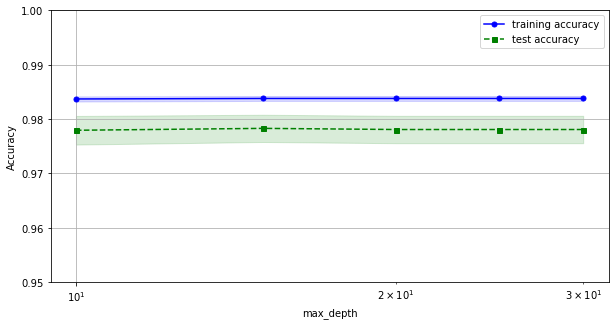

In [62]:
draw_validation_curve(vc_res, [0.95, 1.0]);

### GBDT

In [63]:
learners_name.append("GBDT")

#### initilization

In [64]:
model = GradientBoostingClassifier(min_samples_leaf=10, 
                                   subsample=0.8, 
                                   random_state=my_random_seed, 
                                   learning_rate =0.1)
tuned_parameters = {'max_depth': [10, 15, 20, 25, 30], 'min_samples_split': [10, 15, 20, 25, 30]}

#### Training and optimizations

In [65]:
clf = GridSearchCV(estimator=model,
                   param_grid=tuned_parameters,
                   cv=5,
                   scoring='accuracy',
                   refit=True, 
                   n_jobs=my_multiple_jobs);
start = time.time()
clf.fit(X_train, y_train)
print(clf.best_estimator_)

# timing
end = time.time()
duration = end - start

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=10,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
        

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=25,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=10, min_samples_split=10,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=903, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [66]:
learners_best.append(clf.best_estimator_)

#### Performance analysis

In [67]:
print("Validating V.S. Testing:")
# verification
train_score = clf.score(X_train, y_train)
print('\tValidation Accuracy：{:.3f}%'.format(train_score * 100))

# test
test_score = clf.score(X_test, y_test)
print('\tTesting Accuracy：{:.3f}%'.format(test_score * 100))

print("More classification metrics:")
y_pred = clf.predict(X_test)
y_test_cmp = np.array(y_test)

metrc = recall_score(y_test_cmp,y_pred)
metpr = precision_score(y_test_cmp,y_pred)
metauc = roc_auc_score(y_test_cmp,y_pred)
metac = accuracy_score(y_test_cmp,y_pred)
metf1 = f1_score(y_test_cmp,y_pred)
cm = confusion_matrix(y_test_cmp,y_pred)
metfp = 1.*cm[0,1]/(cm[0,0]+cm[0,1])

print("\tThe Running Time is     {:.4f}s".format(duration))
print("\tThe accuracy is         {0:0.4f}".format(np.mean(metac)))
print("\tThe recall score is     {0:0.4f}".format(np.mean(metrc)))
print("\tThe precision score is  {0:0.4f}".format(np.mean(metpr)))
print("\tThe AUC score is        {0:0.4f}".format(np.mean(metauc)))
print("\tThe f1 score is         {0:0.4f}".format(np.mean(metf1)))
print("\tThe FPR is              {0:0.4e}".format(np.mean(metfp)))

Validating V.S. Testing:
	Validation Accuracy：100.000%
	Testing Accuracy：97.989%
More classification metrics:
	The Running Time is     243.6215s
	The accuracy is         0.9799
	The recall score is     0.8438
	The precision score is  0.9336
	The AUC score is        0.9188
	The f1 score is         0.8864
	The FPR is              6.1595e-03


In [68]:
learners_metric.append([train_score, test_score, duration, np.mean(metf1), np.mean(metpr), np.mean(metrc)])

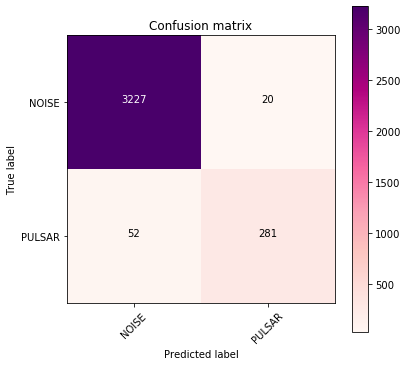

In [69]:
plot_cm(cm,['NOISE','PULSAR'], cmap=plt.cm.RdPu, colmap=True)

#### Learning and Validating curve

In [70]:
# learning curve
lc_res = get_learn_curve_data(model)

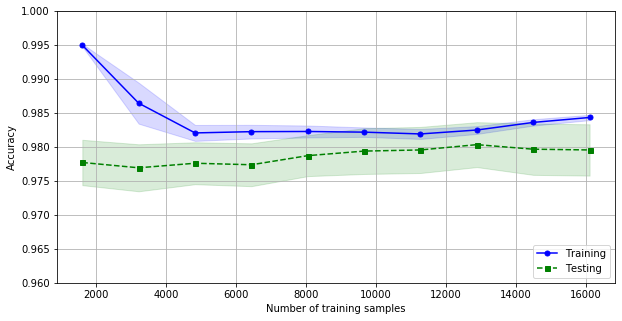

In [71]:
draw_learn_curve(lc_res, [0.96, 1.0])

In [72]:
# validation curve
para_name = list(tuned_parameters.keys())[0]
param_range = list(tuned_parameters.values())[0]
vc_res = get_validation_curve_data(model, para_name, param_range)

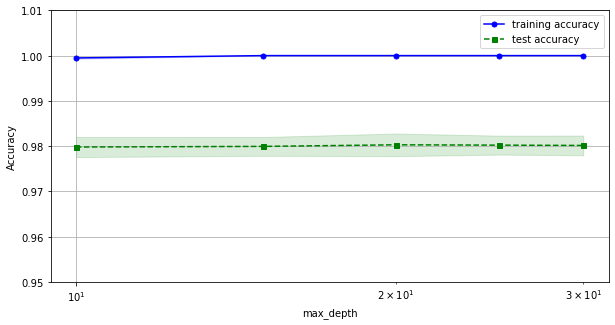

In [73]:
draw_validation_curve(vc_res, [0.95, 1.01]);

### NN

In [74]:
learners_name.append("MLP")

#### initilization

In [75]:
# model = MLPClassifier(activation='relu', solver='sgd', 
#                       learning_rate_init=.01, 
#                       hidden_layer_sizes=(10, 5, 3), 
#                       max_iter=200, 
#                       random_state=my_random_seed, 
#                       warm_start=True)
# tuned_parameters = {'alpha': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]}

In [76]:
model = MLPClassifier(activation='relu', solver='sgd', 
                      learning_rate_init=.01, 
                      hidden_layer_sizes=(10, 10, 5), 
                      random_state=my_random_seed, 
                      warm_start=True)
tuned_parameters = {"max_iter": [50, 100, 150, 200, 300], 'alpha': [1e-2, 1e-3, 1e-4, 1e-5]}

#### Training and optimizations

In [77]:
clf = GridSearchCV(estimator=model,
                   param_grid=tuned_parameters,
                   cv=5,
                   scoring='accuracy',
                   refit=True, 
                   n_jobs=my_multiple_jobs);
start = time.time()
clf.fit(X_train, y_train)
print(clf.best_estimator_)

# timing
end = time.time()
duration = end - start

GridSearchCV(cv=5, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08,
                                     hidden_layer_sizes=(10, 10, 5),
                                     learning_rate='constant',
                                     learning_rate_init=0.01, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=903, shuffle=True,
                                     solver='sgd', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=True),
             iid='deprecated',

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 10, 5), learning_rate='constant',
              learning_rate_init=0.01, max_fun=15000, max_iter=150,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=903, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=True)


In [78]:
learners_best.append(clf.best_estimator_)

#### Performance analysis

In [79]:
print("Validating V.S. Testing:")
# verification
train_score = clf.score(X_train, y_train)
print('\tValidation Accuracy：{:.3f}%'.format(train_score * 100))

# test
test_score = clf.score(X_test, y_test)
print('\tTesting Accuracy：{:.3f}%'.format(test_score * 100))

print("More classification metrics:")
y_pred = clf.predict(X_test)
y_test_cmp = np.array(y_test)

metrc = recall_score(y_test_cmp,y_pred)
metpr = precision_score(y_test_cmp,y_pred)
metauc = roc_auc_score(y_test_cmp,y_pred)
metac = accuracy_score(y_test_cmp,y_pred)
metf1 = f1_score(y_test_cmp,y_pred)
cm = confusion_matrix(y_test_cmp,y_pred)
metfp = 1.*cm[0,1]/(cm[0,0]+cm[0,1])

print("\tThe Running Time is     {:.4f}s".format(duration))
print("\tThe accuracy is         {0:0.4f}".format(np.mean(metac)))
print("\tThe recall score is     {0:0.4f}".format(np.mean(metrc)))
print("\tThe precision score is  {0:0.4f}".format(np.mean(metpr)))
print("\tThe AUC score is        {0:0.4f}".format(np.mean(metauc)))
print("\tThe f1 score is         {0:0.4f}".format(np.mean(metf1)))
print("\tThe FPR is              {0:0.4e}".format(np.mean(metfp)))

Validating V.S. Testing:
	Validation Accuracy：97.989%
	Testing Accuracy：97.877%
More classification metrics:
	The Running Time is     56.8376s
	The accuracy is         0.9788
	The recall score is     0.8318
	The precision score is  0.9327
	The AUC score is        0.9128
	The f1 score is         0.8794
	The FPR is              6.1595e-03


In [80]:
learners_metric.append([train_score, test_score, duration, np.mean(metf1), np.mean(metpr), np.mean(metrc)])

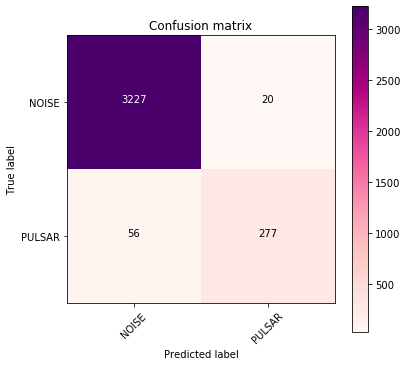

In [81]:
plot_cm(cm,['NOISE','PULSAR'], cmap=plt.cm.RdPu, colmap=True)

#### Learning and Validating curve

In [82]:
# learnging curve
from tensorflow import keras
from tensorflow.keras import utils, preprocessing
from tensorflow.keras import layers, models

nn_model = models.Sequential()
nn_model.add(layers.Dense(10, input_shape=(8,), activation='relu'))
nn_model.add(layers.Dense(10, activation='relu'))
nn_model.add(layers.Dense(5, activation='relu'))
nn_model.add(layers.Dense(1, activation='sigmoid'))

nn_model.summary()

nn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['acc']
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                90        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 261
Trainable params: 261
Non-trainable params: 0
_________________________________________________________________


In [83]:
hist2 = nn_model.fit(X_train, y_train.values, 
                  epochs=100, 
                  validation_data=(X_test, y_test.values), 
                  use_multiprocessing=True)

Train on 14318 samples, validate on 3580 samples
Epoch 1/100
14318/14318 [==============================] - 2s 140us/sample - loss: 0.2799 - acc: 0.9370 - val_loss: 0.0996 - val_acc: 0.9687
Epoch 2/100
14318/14318 [==============================] - 1s 61us/sample - loss: 0.0909 - acc: 0.9733 - val_loss: 0.0895 - val_acc: 0.9735
Epoch 3/100
14318/14318 [==============================] - 1s 61us/sample - loss: 0.0865 - acc: 0.9752 - val_loss: 0.0882 - val_acc: 0.9723
Epoch 4/100
14318/14318 [==============================] - 1s 61us/sample - loss: 0.0851 - acc: 0.9760 - val_loss: 0.0854 - val_acc: 0.9746
Epoch 5/100
14318/14318 [==============================] - 1s 61us/sample - loss: 0.0835 - acc: 0.9758 - val_loss: 0.0851 - val_acc: 0.9735
Epoch 6/100
14318/14318 [==============================] - 1s 61us/sample - loss: 0.0822 - acc: 0.9761 - val_loss: 0.0838 - val_acc: 0.9754
Epoch 7/100
14318/14318 [==============================] - 1s 61us/sample - loss: 0.0817 - acc: 0.9760 - val_l

Epoch 59/100
14318/14318 [==============================] - 1s 61us/sample - loss: 0.0698 - acc: 0.9796 - val_loss: 0.0735 - val_acc: 0.9796
Epoch 60/100
14318/14318 [==============================] - 1s 60us/sample - loss: 0.0706 - acc: 0.9793 - val_loss: 0.0711 - val_acc: 0.9788
Epoch 61/100
14318/14318 [==============================] - 1s 61us/sample - loss: 0.0702 - acc: 0.9797 - val_loss: 0.0723 - val_acc: 0.9799
Epoch 62/100
14318/14318 [==============================] - 1s 60us/sample - loss: 0.0707 - acc: 0.9791 - val_loss: 0.0715 - val_acc: 0.9796
Epoch 63/100
14318/14318 [==============================] - 1s 60us/sample - loss: 0.0702 - acc: 0.9792 - val_loss: 0.0776 - val_acc: 0.9785
Epoch 64/100
14318/14318 [==============================] - 1s 61us/sample - loss: 0.0710 - acc: 0.9795 - val_loss: 0.0740 - val_acc: 0.9788
Epoch 65/100
14318/14318 [==============================] - 1s 61us/sample - loss: 0.0695 - acc: 0.9795 - val_loss: 0.0753 - val_acc: 0.9788
Epoch 66/100


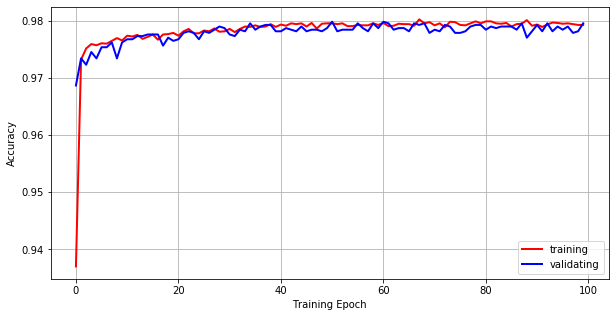

In [84]:
plt.figure(figsize=(10,5))
plt.plot(hist2.epoch, hist2.history.get('acc'), c='r', label="training", linewidth=2)
plt.plot(hist2.epoch, hist2.history.get('val_acc'), c='b', label="validating",  linewidth=2)
plt.xlabel('Training Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid();

In [85]:
# validation curve
para_name = list(tuned_parameters.keys())[0]
param_range = list(tuned_parameters.values())[0]
vc_res = get_validation_curve_data(model, para_name, param_range)

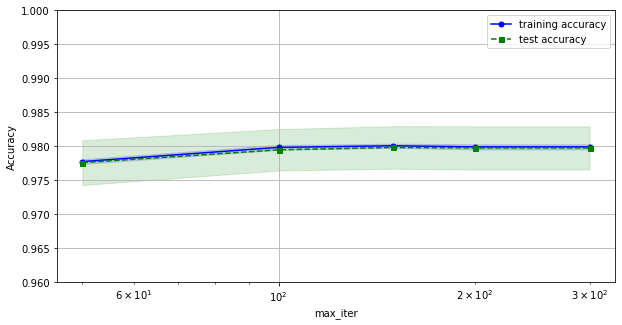

In [86]:
draw_validation_curve(vc_res, [0.96, 1.0]);

## Overall Comparison for  best learners

In [87]:
learners_name

['KNN', 'SVM', 'DTree', 'GBDT', 'MLP']

### ROC curve 

In [88]:
res_roc = {}
for i in range(len(learners_name)):
    each_name = learners_name[i]
    each_learner = learners_best[i]
    res_roc[each_name] = dict()
    
    _ = each_learner.fit(X_train, y_train)
    res_roc[each_name]['fpr'], res_roc[each_name]['tpr'], _ = roc_curve(np.array(y_test), 
                                                                        each_learner.predict_proba(X_test)[:, 1])

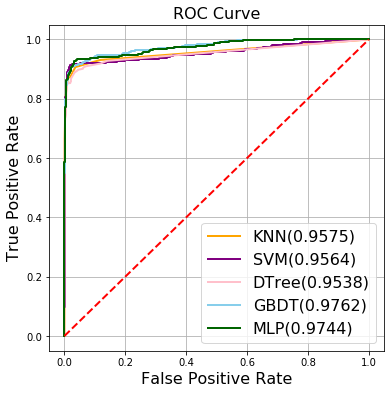

In [89]:
plt.figure(figsize=(6,6))

colors = ['orange','purple','pink','skyblue','darkgreen']
for i in range(len(learners_name)):
    clf_name = learners_name[i]
    tmp_fpr, tmp_tpr = res_roc[clf_name]['fpr'], res_roc[clf_name]['tpr']
    tmp_auc = auc(tmp_fpr, tmp_tpr)
    tmp_auc = "{:.4f}".format(tmp_auc)
    plt.plot(tmp_fpr, tmp_tpr, colors[i], linewidth=2, label=f"{clf_name}({tmp_auc})")
    
plt.plot([0,1],[0,1],'r--', linewidth=2)
plt.title('ROC Curve')
plt.xlabel("False Positive Rate",fontsize=16)
plt.ylabel("True Positive Rate",fontsize=16)
plt.title("ROC Curve",fontsize=16)
plt.legend(loc="lower right",fontsize=16)
plt.grid();

### Metrics Comparison

In [90]:
if len(learners_metric) == 5 and len(learners_name) == 5:
    metrics_name = ["Validate_acc", "Test_acc", "Run-time", "F1-score", "Precision", "Recall"]
    df_metric = pd.DataFrame(learners_metric, columns=metrics_name)
    df_metric['learners'] = learners_name
    df_metric

Validate_acc  Test_acc    Run-time  F1-score  Precision    Recall learners
0      0.978838  0.978492    1.579893  0.876404   0.941379  0.819820      KNN
1      0.981422  0.978212   18.220736  0.874598   0.941176  0.816817      SVM
2      0.983517  0.978212    0.433209  0.876582   0.926421  0.831832    DTree
3      1.000000  0.979888  243.621453  0.886435   0.933555  0.843844     GBDT
4      0.979885  0.978771   56.837641  0.879365   0.932660  0.831832      MLP

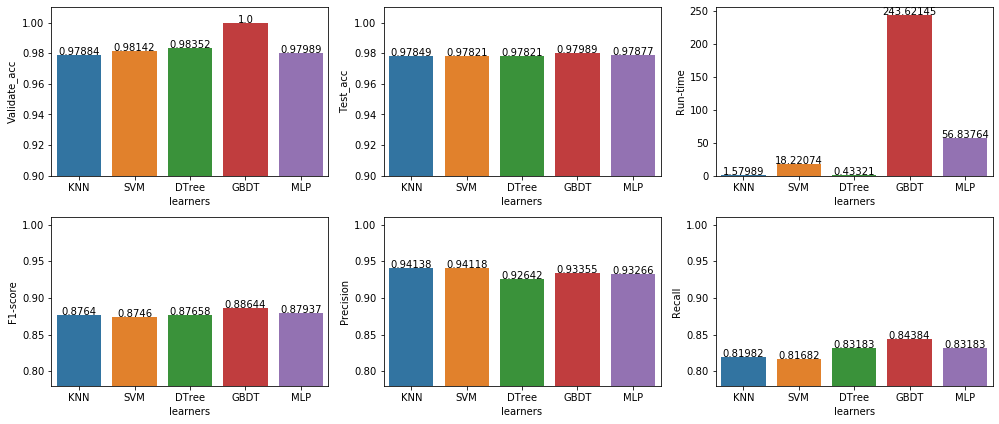

In [91]:
plt.figure(figsize=(14, 6))
for i in range(len(metrics_name)):
    plt.subplot(2,3,i+1)
    y_name = metrics_name[i]
    g = sns.barplot(data=df_metric, x="learners", y=y_name)
    for index, row in df_metric.iterrows():
        g.text(row.name,row[y_name],round(row[y_name],5),color="black",ha="center");
    if i < 2:
        plt.ylim([0.9, 1.01])
    elif i > 2:
        plt.ylim([0.78, 1.01])
plt.tight_layout();

## Ensemble learning